#Generating plots for paper

In [1]:
import os
import pickle
import pystan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import data_helpers as helpers

# put figs together using svgutils (see http://neuroscience.telenczuk.pl/?p=331)
# import svgutils.transform as sg

%matplotlib inline

# set some styles we like:
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("paper")
# sns.set_palette("deep")


# set up the figure path:
top_dir = helpers.project_directory()
fig_dir = os.path.join(top_dir, 'figures')

experiment_num = 10
model_name = 'tanh3'

In [2]:
# load image info - how many images?
image_info = pd.read_csv(os.path.join(top_dir, 'stimuli', 
                                      ('experiment-' + str(experiment_num)),
                                      'final_ims', 'patch_info.csv'), 
                         index_col=False)
image_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 699
Data columns (total 4 columns):
filename    700 non-null object
sal_mean    700 non-null float64
sal_sd      700 non-null float64
size        700 non-null float64
dtypes: float64(3), object(1)
memory usage: 27.3+ KB


In [3]:
image_info.groupby(['size']).size()

size
32      100
64      100
128     100
192     100
256     100
384     100
512     100
dtype: int64

In [4]:
# load unprocessed data, determine eye movement discarding:
dat = pd.read_csv(os.path.join(top_dir, 'results', 
                               ('experiment-' + str(experiment_num)), 
                               'all_data.csv'), index_col=False)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 0 to 4799
Data columns (total 22 columns):
cond             4800 non-null object
surround_cond    4800 non-null object
oddball          4800 non-null int64
im_code          4800 non-null object
target_loc       4800 non-null int64
jitter_1         4800 non-null float64
jitter_2         4800 non-null float64
jitter_3         4800 non-null float64
subj             4800 non-null object
session          4800 non-null int64
eccent           4800 non-null int64
patch_size_px    4800 non-null int64
scale            4800 non-null float64
test_location    4800 non-null object
rand_seed        4800 non-null float64
trial            4800 non-null int64
response         4800 non-null object
rt               4789 non-null float64
correct          4789 non-null float64
eye_invalid      4795 non-null float64
eye_sd_deg       4784 non-null float64
time_invalid     4795 non-null float64
dtypes: float64(10), int64(6), object(6)
memory usage

In [5]:
dat.groupby(['subj']).eye_invalid.sum() / dat.groupby(['subj']).eye_invalid.size()

subj
S1      0.008333
S2      0.248750
dtype: float64

In [6]:
dat.time_invalid.sum()

11.0

In [7]:
dat.time_invalid.sum() / dat.time_invalid.size

0.0022916666666666667

In [8]:
processed = helpers.experiment_10_data_ready_for_analysis(dat)
processed.groupby(['subj']).size()

/Users/tomwallis/miniconda3/envs/default/lib/python3.4/site-packages/pandas/core/frame.py:2417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
/Users/tomwallis/Dropbox/Projects/metamers-natural-scenes/code/analysis/data_helpers.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dat['patch_size'] = _np.round(dat.loc[:, 'scale'] * 10., decimals=2)
/Users/tomwallis/Dropbox/Projects/metamers-natural-scenes/code/analysis/data_helpers.py:279: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://p

subj
S1      2380
S2      1803
dtype: int64

In [9]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4183 entries, 0 to 4794
Data columns (total 22 columns):
cond             4183 non-null object
surround         4183 non-null object
oddball          4183 non-null int64
im_code          4183 non-null object
target_loc       4183 non-null int64
jitter_1         4183 non-null float64
jitter_2         4183 non-null float64
jitter_3         4183 non-null float64
subj             4183 non-null object
session          4183 non-null int64
eccent           4183 non-null int64
patch_size_px    4183 non-null int64
test_location    4183 non-null object
rand_seed        4183 non-null float64
trial            4183 non-null int64
response         4183 non-null object
rt               4176 non-null float64
correct          4176 non-null float64
eye_invalid      4178 non-null float64
eye_sd_deg       4167 non-null float64
time_invalid     4178 non-null float64
patch_size       4183 non-null float64
dtypes: float64(10), int64(6), object(6)
memory usage

In [10]:
# load data from fit:
with open (os.path.join(top_dir, 'results', ('experiment-' + str(experiment_num)), 
                        ('expt_' + str(experiment_num) + '_' + 
                         model_name + '_full_model_fit.pkl')), 'rb') as f:
    stan_model, fit, plot_df, param_df, pop_param_df = pickle.load(f)

# change condition names for plotting:
plot_df.loc[plot_df['surround'] == 'surround', 'surround'] = 'synth'
param_df.loc[param_df['surround'] == 'surround', 'surround'] = 'synth'
pop_param_df.loc[pop_param_df['surround'] == 'surround', 'surround'] = 'synth'


In [11]:
# print(fit)

## Subject model fits

In [12]:
# set up plot functions to be used with map_dataframe:
def plot_chance(*args, **kwargs):
    data = kwargs.pop('data')
    plt.plot((0, 12), (0.33, 0.33), ls='--', color='0.7')

    
def plot_preds(*args, **kwargs):
    data = kwargs.pop('data')
    x_col, y_col, sample_col = args
    for i in range(n_samples):
        x = data.loc[data[sample_col]==i, x_col]
        y = data.loc[data[sample_col]==i, y_col]
        kwargs['marker'] = None        
        plt.plot(x, y, **kwargs)

def plot_errors(*args, **kwargs):
    data = kwargs.pop('data')
    x_col, y_col, mask_on = args
    mask = np.isnan(data[mask_on])    
    errors = np.vstack([data.loc[mask, 'error_min'], 
                        data.loc[mask, 'error_max']])

    plt.errorbar(data.loc[mask, x_col], 
                 data.loc[mask, y_col], 
                 yerr=errors,
                 **kwargs);        

In [32]:
# relabel cond so that legend looks nicer:
plot_df.loc[plot_df['cond'] == 'nat_v_synth', 'cond'] = 'nat vs synth'
plot_df.loc[plot_df['cond'] == 'synth_v_synth', 'cond'] = 'synth vs synth'

n_samples = 100

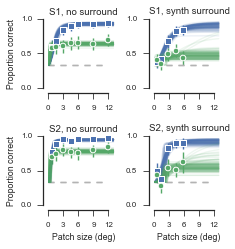

In [43]:
# plot:
g = sns.FacetGrid(plot_df, row='subj', col='surround', hue='cond', hue_kws={'marker': ['s', 'o']},
                  dropna=False,
                  size=3.5/2)
g.map_dataframe(plot_chance)
g.map_dataframe(plot_preds, 'patch_size', 'yhat', 'sample', 
                alpha=0.1)
g.map_dataframe(plot_errors, 'patch_size', 'prop_corr', 'yhat',
                linestyle='none', 
                mec='w', mew=1, capsize=0)
g.set_axis_labels('Patch size (deg)', 'Proportion correct')
g.set(xticks=np.linspace(0, 12, num=5), yticks=np.linspace(0, 1, num=3))

# set shorter titles for facets:
titles = ["S1, no surround",
          "S1, synth surround",
          "S2, no surround",
          "S2, synth surround"]

for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

g.fig.subplots_adjust(wspace=0.5, hspace=0.7)
sns.despine(offset=5, trim=True);

In [44]:
g.fig.set_figwidth(3.5)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_fits.pdf'), bbox_inches='tight')

# g = set_figure_processing(g)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_fits.svg'), bbox_inches='tight')


## Critical scale parameters

In [16]:
# melt this into a tidy frame:
melted = pd.melt(param_df, id_vars=['subj','surround', 'cond', 'sample'],
                 var_name='param',
                 value_name='value')
melted.head()

,subj,surround,cond,sample,param,value
0,S1,blank,nat_v_synth,0,alpha,4.388063
1,S2,blank,nat_v_synth,0,alpha,4.685878
2,S1,blank,synth_v_synth,0,alpha,2.155327
3,S2,blank,synth_v_synth,0,alpha,2.776984
4,S1,synth,nat_v_synth,0,alpha,3.992873


In [17]:
np.unique(melted['param'])

array(['alpha', 'beta', 'critical_scale', 'prior_alpha', 'prior_beta',
       'prior_critical_scale'], dtype=object)

In [18]:
# plot absolute parameter values:
def plot_violins(*args, **kwargs):
    param, = args
    data = kwargs.pop('data')
    # select desired parameter:
    data = data.loc[data['param'] == param, :]
    pos = np.array([2.])
    
    # for each subject:
    for s in np.unique(data['subj']):
        if np.any(data['cond']=='nat_v_synth'):
            this_pos = pos - 0.5
        else:
            this_pos = pos + 0.5
        
        # crop data to 95% middle:
        x = data.loc[data['subj'] == s, 'value'].values
        x = x[x >= np.percentile(x, 2.5)]
        x = x[x <= np.percentile(x, 97.5)]
        
        # stupid violinplot color setting:
        # https://stackoverflow.com/questions/26291479/changing-the-color-of-matplotlibs-violin-plots
        result = plt.violinplot(x, this_pos, 
                                showmeans=False,
                                showmedians=True,
                                showextrema=False,
                                widths=1.)
        for patch in result['bodies']: 
            patch.set_color(kwargs['color'])
            patch.set_label(kwargs['label'])
            patch.set_alpha(kwargs['alpha'])

        # set colour of mean:
#         result['cmeans'].set_color('k')
#         result['cmeans'].set_alpha(kwargs['alpha'])
        result['cmedians'].set_color('k')
        result['cmedians'].set_alpha(kwargs['alpha'])


        # increment the position:
        pos += 4


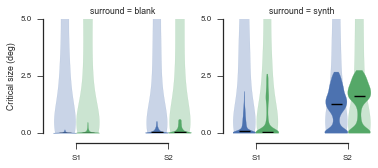

In [19]:
g = sns.FacetGrid(melted, 
                  col='surround', hue='cond',
                  size=2.5)
g.map_dataframe(plot_violins, 'prior_critical_scale', alpha=0.3)
g.map_dataframe(plot_violins, 'critical_scale', alpha=1)
g.set(xticks=[2., 6.],
      xticklabels=np.unique(melted['subj']))
g.set(ylim=[0, 5])
g.set(yticks=np.linspace(0, 5, num=3))
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Critical size (deg)')
sns.despine(offset=10, trim=True);

In [20]:
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_critical_scale.pdf'), bbox_inches='tight')

# g = set_figure_processing(g)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_critical_scale.svg'), bbox_inches='tight')


## Same for gain parameters

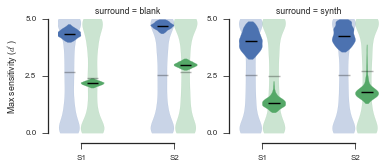

In [21]:
g = sns.FacetGrid(melted, 
                  col='surround', hue='cond',
                  size=2.5)
g.map_dataframe(plot_violins, 'prior_alpha', alpha=0.3)
g.map_dataframe(plot_violins, 'alpha', alpha=1)
g.set(xticks=[2., 6.],
      xticklabels=np.unique(melted['subj']))
g.set(yticks=np.linspace(0, 5, num=3))

# g.set(ylim=[0, 0.1])
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Max sensitivity ($d^\prime$)')
sns.despine(offset=10, trim=True);

In [22]:
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_gain.pdf'), bbox_inches='tight')

# g = set_figure_processing(g)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_gain.svg'), bbox_inches='tight')


## Same for slope

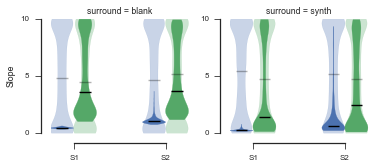

In [23]:
g = sns.FacetGrid(melted, 
                  col='surround', hue='cond',
                  size=2.5)
g.map_dataframe(plot_violins, 'prior_beta', alpha=0.3)
g.map_dataframe(plot_violins, 'beta', alpha=1)
g.set(xticks=[2., 6.],
      xticklabels=np.unique(melted['subj']))
g.set(yticks=np.linspace(0, 10, num=3))

# g.set(ylim=[0, 0.1])
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Slope')
sns.despine(offset=10, trim=True);

In [24]:
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_slope.pdf'), bbox_inches='tight')

# g = set_figure_processing(g)
g.savefig(os.path.join(fig_dir, 'expt_' + str(experiment_num) + '_' + 
                       model_name + '_params_slope.svg'), bbox_inches='tight')


## How does the population mu change from prior to posterior?


In [25]:
pop_param_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 0 to 3
Data columns (total 9 columns):
surround                   16000 non-null object
cond                       16000 non-null object
sample                     16000 non-null int64
mu_alpha                   16000 non-null float64
mu_beta                    16000 non-null float64
mu_critical_scale          16000 non-null float64
prior_mu_alpha             16000 non-null float64
prior_mu_beta              16000 non-null float64
prior_mu_critical_scale    16000 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.2+ MB


In [26]:
pop_melted = pd.melt(pop_param_df, id_vars=['surround', 'cond', 'sample'],
                 var_name='param',
                 value_name='value')
pop_melted.head()

,surround,cond,sample,param,value
0,blank,nat_v_synth,0,mu_alpha,4.004933
1,blank,synth_v_synth,0,mu_alpha,1.232162
2,synth,nat_v_synth,0,mu_alpha,4.505534
3,synth,synth_v_synth,0,mu_alpha,3.679035
4,blank,nat_v_synth,1,mu_alpha,2.606224


In [27]:
np.unique(pop_melted['param'])

array(['mu_alpha', 'mu_beta', 'mu_critical_scale', 'prior_mu_alpha',
       'prior_mu_beta', 'prior_mu_critical_scale'], dtype=object)

In [28]:
def plot_pop_violins(*args, **kwargs):
    param, = args
    data = kwargs.pop('data')
    # select desired parameter:
    data = data.loc[data['param'] == param, :]
    
    if np.any(data['cond']=='nat_v_synth'):
        this_pos = np.array([- 0.5])
    else:
        this_pos = np.array([+ 0.5])

    # crop data to 95% middle:
    x = data.loc[:, 'value'].values
    x = x[x >= np.percentile(x, 2.5)]
    x = x[x <= np.percentile(x, 97.5)]

    # stupid violinplot color setting:
    # https://stackoverflow.com/questions/26291479/changing-the-color-of-matplotlibs-violin-plots
    result = plt.violinplot(x, this_pos, 
                            showmeans=False,
                            showmedians=True,
                            showextrema=False,
                            widths=1.)
    for patch in result['bodies']: 
        patch.set_color(kwargs['color'])
        patch.set_label(kwargs['label'])
        patch.set_alpha(kwargs['alpha'])

    result['cmedians'].set_color('k')
    result['cmedians'].set_alpha(kwargs['alpha'])

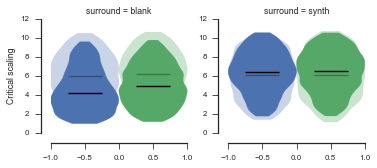

In [29]:
g = sns.FacetGrid(pop_melted, 
                  col='surround', hue='cond',
                  size=2.5)
g.map_dataframe(plot_pop_violins, 'prior_mu_critical_scale', alpha=0.3)
g.map_dataframe(plot_pop_violins, 'mu_critical_scale', alpha=1)
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Critical scaling')
sns.despine(offset=10, trim=True);

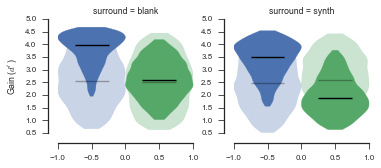

In [30]:
g = sns.FacetGrid(pop_melted, 
                  col='surround', hue='cond',
                  size=2.5)
g.map_dataframe(plot_pop_violins, 'prior_mu_alpha', alpha=0.3)
g.map_dataframe(plot_pop_violins, 'mu_alpha', alpha=1)
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Gain ($d^\prime$)')
sns.despine(offset=10, trim=True);

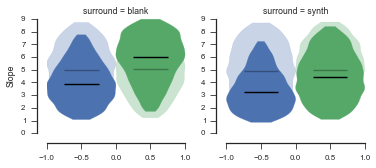

In [31]:
g = sns.FacetGrid(pop_melted, 
                  col='surround', hue='cond',
                  size=2.5)
g.map_dataframe(plot_pop_violins, 'prior_mu_beta', alpha=0.3)
g.map_dataframe(plot_pop_violins, 'mu_beta', alpha=1)
g.fig.subplots_adjust(wspace=0.3)
g.set_axis_labels('', 'Slope')
sns.despine(offset=10, trim=True);